In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import mean_squared_error


In [126]:
# Load the dataset to examine its structure and contents
file_path = 'AirQualityUCI.csv'
data = pd.read_csv(file_path, delimiter=';', decimal=',', skipinitialspace=True)

# Display the first few rows and column information
data_info = {
    "head": data.head(),
    "columns": data.columns.tolist(),
    "info": data.info()
}
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


{'head':          Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
 0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
 1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
 2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
 3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
 4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   
 
    PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
 0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
 1          955.0    103.0        1174.0     92.0        1559.0        972.0   
 2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
 3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
 4          836.0    131.0        1205.0    116.0        1490.0       1110.0   
 
       T    RH      AH  Unnamed: 15  Unnamed: 16  
 0  13.6  48.9  0.7578          NaN        

In [127]:
# Update the cleaning process: drop fully NaN columns but only drop rows with NaN in critical columns
data_cleaned = data.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

# Combine 'Date' and 'Time' into a single 'Datetime' column
data_cleaned['Datetime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], errors='coerce')
data_cleaned = data_cleaned.drop(columns=['Date', 'Time'])

# Drop rows with NaN in the critical columns (e.g., sensor readings)
critical_columns = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'T', 'RH', 'AH']
data_cleaned = data_cleaned.dropna(subset=critical_columns)

# Reset the index after cleaning
data_cleaned = data_cleaned.reset_index(drop=True)

# Display the updated summary of the cleaned dataset
data_summary_updated = {
    "shape": data_cleaned.shape,
    "columns": data_cleaned.columns.tolist(),
    "head": data_cleaned.head()
}
data_summary_updated

C:\Users\ccoos\AppData\Local\Temp\ipykernel_20072\3086748908.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_cleaned['Datetime'] = pd.to_datetime(data_cleaned['Date'] + ' ' + data_cleaned['Time'], errors='coerce')


{'shape': (9357, 14),
 'columns': ['CO(GT)',
  'PT08.S1(CO)',
  'NMHC(GT)',
  'C6H6(GT)',
  'PT08.S2(NMHC)',
  'NOx(GT)',
  'PT08.S3(NOx)',
  'NO2(GT)',
  'PT08.S4(NO2)',
  'PT08.S5(O3)',
  'T',
  'RH',
  'AH',
  'Datetime'],
 'head':    CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
 0     2.6       1360.0     150.0      11.9         1046.0    166.0   
 1     2.0       1292.0     112.0       9.4          955.0    103.0   
 2     2.2       1402.0      88.0       9.0          939.0    131.0   
 3     2.2       1376.0      80.0       9.2          948.0    172.0   
 4     1.6       1272.0      51.0       6.5          836.0    131.0   
 
    PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
 0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578   
 1        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255   
 2        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502   
 3        1092.0    122.0        1

In [128]:
# Example Dataset Preparation (replace this with cleaned data)
def prepare_data(data, sequence_length):
    features = data[:, :-1]
    targets = data[:, -1]
    
    sequences = []
    labels = []

    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i + sequence_length])
        labels.append(targets[i + sequence_length])

    return np.array(sequences), np.array(labels)

In [129]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, pooling_type=None):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.pooling_type = pooling_type
        self.fc = nn.Linear(hidden_size, output_size)

        # Define the pooling layers
        if self.pooling_type == 'max':
            self.pooling = nn.MaxPool1d(kernel_size=2)
        elif self.pooling_type == 'avg':
            self.pooling = nn.AvgPool1d(kernel_size=2)
        else:
            self.pooling = None
        
    def forward(self, x):
        out, _ = self.rnn(x)

        if self.pooling_type:
            out = out.permute(0, 2, 1)  # Change shape for pooling (batch, features, sequence)
            out = self.pooling(out)
            out = out.permute(0, 2, 1)  # Revert back to (batch, sequence, features)
        
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)
        return out

# Function to prepare data
def prepare_data(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length, :-1])  # Input sequence (all features except last column)
        labels.append(data[i+sequence_length, -1])  # Label (last column as target)
    return np.array(sequences), np.array(labels)

In [130]:
# Hyperparameters
input_size = 10  # Example input size (replace with actual data features)
hidden_sizes = [16, 32, 64]
num_layers = 2
output_size = 1  # Example output size (e.g., regression target)
sequence_length = 10
batch_size = 32
learning_rate = 0.001
epochs_list = [5, 50, 100, 250, 350]  # Compare different epochs
pooling_types = [None, 'max', 'avg']  # No pooling, MaxPooling, and AvgPooling
optimizers_list = ['sgd', 'rmsprop', 'adam']  # Different optimizers

In [131]:
# Example dataset (randomly generated for structure)
data = np.random.rand(1000, input_size + 1)
sequences, labels = prepare_data(data, sequence_length)

torch_sequences = torch.tensor(sequences, dtype=torch.float32)
torch_labels = torch.tensor(labels, dtype=torch.float32)

dataset = TensorDataset(torch_sequences, torch_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
# Check for GPU availability
print("Num GPUs Available: ", torch.cuda.device_count())
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Pilih GPU pertama (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Num GPUs Available:  1
Using GPU: NVIDIA GeForce GTX 1650


In [133]:
# Training Loop
def train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper, csv_path):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        
        # Append the results to CSV after every epoch
        epoch_result = {
            "epoch": epoch + 1,
            "loss": avg_loss,
            "hidden_size": hidden_size,
            "pooling_type": pooling_type if pooling_type else 'None',
            "optimizer": optimizer_name,
            "epochs": epochs
        }
        df = pd.DataFrame([epoch_result])
        df.to_csv(csv_path, mode='a', header=not pd.io.common.file_exists(csv_path), index=False)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

        # Early stopping check
        early_stopper(avg_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break
        
        # Learning rate scheduler step
        scheduler.step()

# Initialize the CSV file before starting the training
csv_path = "training_results_combined.csv"
columns = ["epoch", "loss", "hidden_size", "pooling_type", "optimizer", "epochs"]
df_columns = pd.DataFrame(columns=columns)
df_columns.to_csv(csv_path, index=False)

In [134]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if loss < self.best_loss - self.delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [135]:
# Compare different combinations of epochs, optimizers, and pooling types
for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for optimizer_name in optimizers_list:
            for epochs in epochs_list:
                model = RNNModel(input_size, hidden_size, output_size, num_layers, pooling_type)
                criterion = nn.MSELoss()

                # Select optimizer
                if optimizer_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'rmsprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                elif optimizer_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Learning rate scheduler (adjust learning rate every 10 epochs)
                scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

                # Early stopping
                early_stopper = EarlyStopping(patience=5, delta=0.01)

                print(f"\nTraining with Hidden Size: {hidden_size}, Pooling: {pooling_type if pooling_type else 'None'}, Optimizer: {optimizer_name}, Epochs: {epochs}")
                
                # Train model and append results to CSV
                train_model(model, dataloader, optimizer, criterion, epochs, scheduler, early_stopper, csv_path)


Training with Hidden Size: 16, Pooling: None, Optimizer: sgd, Epochs: 5
Epoch [1/5], Loss: 0.1621
Epoch [2/5], Loss: 0.1144
Epoch [3/5], Loss: 0.0974
Epoch [4/5], Loss: 0.0915
Epoch [5/5], Loss: 0.0896

Training with Hidden Size: 16, Pooling: None, Optimizer: sgd, Epochs: 50
Epoch [1/50], Loss: 0.4156
Epoch [2/50], Loss: 0.2498
Epoch [3/50], Loss: 0.1667
Epoch [4/50], Loss: 0.1255
Epoch [5/50], Loss: 0.1053
Epoch [6/50], Loss: 0.0956
Epoch [7/50], Loss: 0.0908
Epoch [8/50], Loss: 0.0885
Epoch [9/50], Loss: 0.0874
Epoch [10/50], Loss: 0.0870
Epoch [11/50], Loss: 0.0867
Epoch [12/50], Loss: 0.0866
Early stopping triggered

Training with Hidden Size: 16, Pooling: None, Optimizer: sgd, Epochs: 100
Epoch [1/100], Loss: 0.2463
Epoch [2/100], Loss: 0.1487
Epoch [3/100], Loss: 0.1113
Epoch [4/100], Loss: 0.0969
Epoch [5/100], Loss: 0.0913
Epoch [6/100], Loss: 0.0892
Epoch [7/100], Loss: 0.0882
Epoch [8/100], Loss: 0.0880
Epoch [9/100], Loss: 0.0878
Early stopping triggered

Training with Hidd

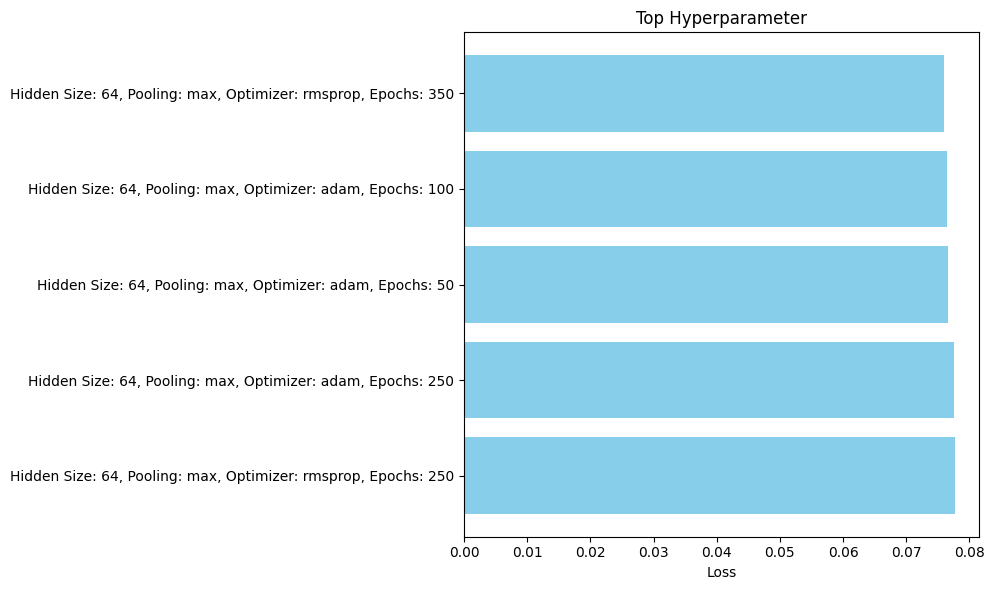

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the training results CSV file
df = pd.read_csv("training_results_combined.csv")

# Sort by the lowest loss (ascending) and select the top 5 best configurations
top_5_results = df.sort_values(by='loss').head(5)

# Prepare data for the bar plot
hyperparameters = []
loss_values = []

for index, row in top_5_results.iterrows():
    config = f"Hidden Size: {row['hidden_size']}, Pooling: {row['pooling_type']}, Optimizer: {row['optimizer']}, Epochs: {row['epochs']}"
    hyperparameters.append(config)
    loss_values.append(row['loss'])

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(hyperparameters, loss_values, color='skyblue')
plt.xlabel('Loss')
plt.title('Top Hyperparameter')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best result on top
plt.tight_layout()
plt.show()


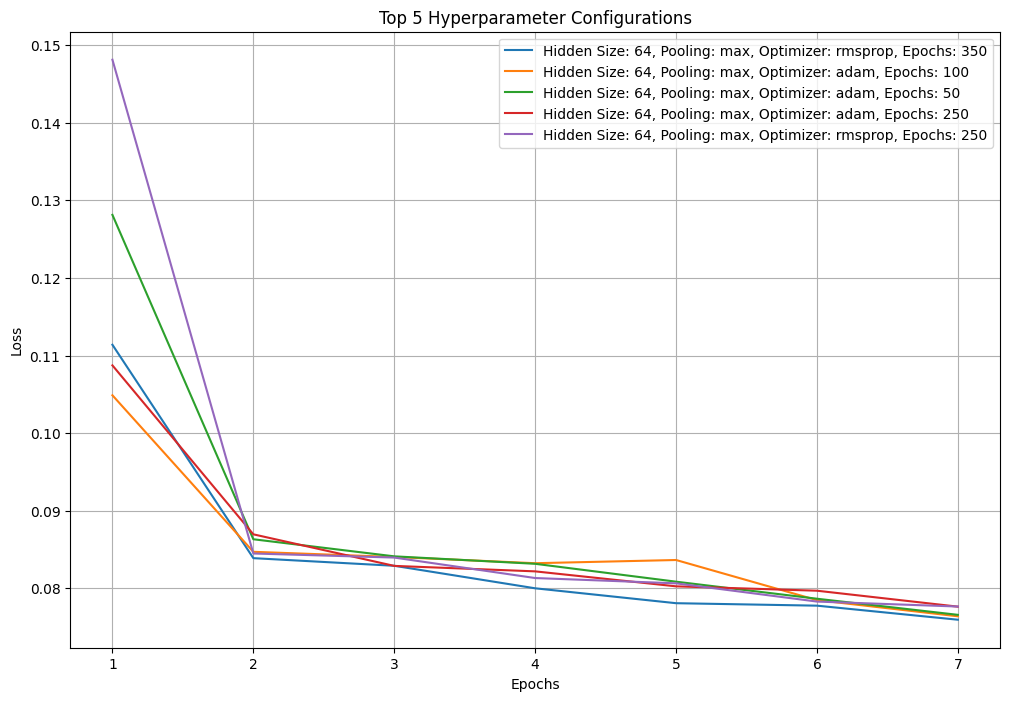

In [137]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file containing the training results
csv_path = "training_results_combined.csv"
df = pd.read_csv(csv_path)

# Sort by the best (lowest) final loss and select the top 5 configurations
# Group by the hyperparameters and select the final loss for sorting
best_configurations = df.groupby(["hidden_size", "pooling_type", "optimizer", "epochs"]).tail(1)
best_configurations = best_configurations.sort_values(by="loss", ascending=True).head(5)

# Plot the loss for each epoch of the top 5 configurations
plt.figure(figsize=(12, 8))

# Iterate through the top 5 configurations and plot the loss over epochs
for idx, config in best_configurations.iterrows():
    filtered_df = df[(df["hidden_size"] == config["hidden_size"]) &
                     (df["pooling_type"] == config["pooling_type"]) &
                     (df["optimizer"] == config["optimizer"]) &
                     (df["epochs"] == config["epochs"])]
    
    # Plot the loss for this configuration
    plt.plot(filtered_df["epoch"], filtered_df["loss"], label=f"Hidden Size: {config['hidden_size']}, "
                                                                f"Pooling: {config['pooling_type'] if config['pooling_type'] else 'None'}, "
                                                                f"Optimizer: {config['optimizer']}, "
                                                                f"Epochs: {config['epochs']}")
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Top 5 Hyperparameter Configurations")
plt.legend()
plt.grid(True)
plt.show()
